In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/data/GAN/clean-normal.zip > /dev/null

In [10]:
!unzip drive/MyDrive/data/GAN/fail.zip > /dev/null

In [ ]:
codings_size = 100
batch_size = 32
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
path = glob.glob("./clean-normal/*.jpg")

def get_image():
   for file in path:
     img = plt.imread(file)
     img = img[30:-50]
     img = cv2.resize(img , (256,256))
     img = img / 255. * 2. - 1.
     yield img

dataset = tf.data.Dataset.from_generator(get_image, output_types=(tf.float32))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

no_of_batches= int(len(path) / batch_size)

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        image = (image + 1.) / 2.
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=1000):
    generator, discriminator = gan.layers
    for i, epoch in enumerate(range(n_epochs)):
      disc_metrics=[]
      gan_metrics=[]
      print("Epoch {}/{}".format(epoch + 1, n_epochs))
      for j,  X_batch in enumerate(tqdm(dataset, total= no_of_batches)):
          gan.reset_metrics()
          X_batch = tf.cast(X_batch, tf.float32)
          # phase 1 - training the discriminator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          generated_images = generator(noise)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
          y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
          discriminator.trainable = True
          logs= discriminator.train_on_batch(X_fake_and_real, y1)
          disc_metrics.append(logs)
          # phase 2 - training the generator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          y2 = tf.constant([[1.]] * batch_size)
          discriminator.trainable = False
          logs= gan.train_on_batch(noise, y2)
          gan_metrics.append(logs)
      disc_metrics = np.mean(disc_metrics, axis=0)
      gan_metrics = np.mean(gan_metrics, axis=0)
      print("Dis: loss= {:.4f}, mae= {:.4f}, acc= {:.4f}\nGAN: loss= {:.4f}, mae= {:.4f}, acc= {:.4f}".format(
          disc_metrics[0], disc_metrics[1], disc_metrics[2], gan_metrics[0], gan_metrics[1], gan_metrics[2])
      )
      if i % 20 == 0:
        plot_multiple_images(generated_images, 8)
        plt.show()
      if i % 100 == 0:
        gan.save("./drive/MyDrive/models/GAN/5_1_gan_{}.hdf5".format(i))

In [ ]:
generator = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 256, input_shape=[codings_size]),
    keras.layers.Reshape([16, 16, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh")
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[256, 256, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)), 
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)), 
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [1]:
generator.summary()
discriminator.summary()

NameError: ignored

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])


Epoch 1/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.0754, mae= 0.0362, acc= 0.9683
GAN: loss= 17.1116, mae= 0.8307, acc= 0.1667


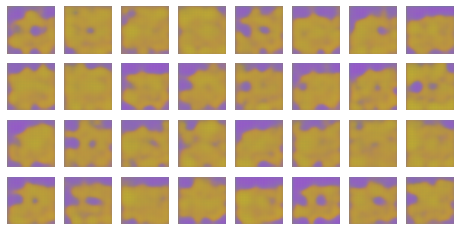

Epoch 2/400


100%|██████████| 228/228 [00:57<00:00,  3.99it/s]


Dis: loss= 0.0939, mae= 0.0187, acc= 0.9873
GAN: loss= 17.9140, mae= 0.9632, acc= 0.0302
Epoch 3/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.0592, mae= 0.0226, acc= 0.9834
GAN: loss= 15.9767, mae= 0.9286, acc= 0.0596
Epoch 4/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.0764, mae= 0.0300, acc= 0.9840
GAN: loss= 3.1545, mae= 0.7340, acc= 0.2352
Epoch 5/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.2223, mae= 0.1312, acc= 0.9287
GAN: loss= 2.9435, mae= 0.8096, acc= 0.1208
Epoch 6/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.3228, mae= 0.1880, acc= 0.8685
GAN: loss= 2.1429, mae= 0.7189, acc= 0.2198
Epoch 7/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.2196, mae= 0.1400, acc= 0.9165
GAN: loss= 2.4408, mae= 0.8025, acc= 0.1072
Epoch 8/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.2208, mae= 0.1321, acc= 0.9198
GAN: loss= 2.7037, mae= 0.7243, acc= 0.2308
Epoch 9/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.2826, mae= 0.1605, acc= 0.8990
GAN: loss= 2.3163, mae= 0.7468, acc= 0.1831
Epoch 10/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.2840, mae= 0.1590, acc= 0.8984
GAN: loss= 3.5497, mae= 0.8382, acc= 0.0979
Epoch 11/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.2820, mae= 0.1581, acc= 0.8905
GAN: loss= 2.9066, mae= 0.7422, acc= 0.2292
Epoch 12/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.2998, mae= 0.1728, acc= 0.8905
GAN: loss= 2.0768, mae= 0.7159, acc= 0.2192
Epoch 13/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.3546, mae= 0.1959, acc= 0.8517
GAN: loss= 2.9347, mae= 0.8240, acc= 0.1169
Epoch 14/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.3576, mae= 0.1822, acc= 0.8749
GAN: loss= 3.1573, mae= 0.8239, acc= 0.1253
Epoch 15/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.3485, mae= 0.2055, acc= 0.8636
GAN: loss= 2.5571, mae= 0.8036, acc= 0.1197
Epoch 16/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.3702, mae= 0.2083, acc= 0.8603
GAN: loss= 2.6838, mae= 0.8125, acc= 0.1124
Epoch 17/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.3921, mae= 0.2323, acc= 0.8440
GAN: loss= 2.2992, mae= 0.7397, acc= 0.1837
Epoch 18/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.3162, mae= 0.1845, acc= 0.8776
GAN: loss= 2.3778, mae= 0.7285, acc= 0.2289
Epoch 19/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.3303, mae= 0.1940, acc= 0.8636
GAN: loss= 2.9222, mae= 0.8271, acc= 0.1147
Epoch 20/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.3689, mae= 0.2024, acc= 0.8559
GAN: loss= 2.9394, mae= 0.8096, acc= 0.1269
Epoch 21/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.4381, mae= 0.2387, acc= 0.8332
GAN: loss= 2.3171, mae= 0.7716, acc= 0.1573


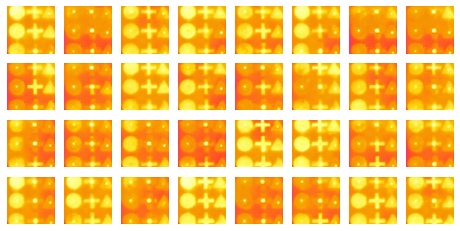

Epoch 22/400


100%|██████████| 228/228 [00:57<00:00,  3.99it/s]


Dis: loss= 0.3983, mae= 0.2171, acc= 0.8588
GAN: loss= 2.3364, mae= 0.7672, acc= 0.1595
Epoch 23/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.4349, mae= 0.2674, acc= 0.8070
GAN: loss= 2.2507, mae= 0.7553, acc= 0.1615
Epoch 24/400


100%|██████████| 228/228 [00:57<00:00,  3.97it/s]


Dis: loss= 0.3581, mae= 0.2155, acc= 0.8475
GAN: loss= 3.0752, mae= 0.8527, acc= 0.0755
Epoch 25/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.4135, mae= 0.2344, acc= 0.8196
GAN: loss= 2.6476, mae= 0.7855, acc= 0.1475
Epoch 26/400


100%|██████████| 228/228 [00:56<00:00,  4.00it/s]


Dis: loss= 0.4058, mae= 0.2384, acc= 0.8171
GAN: loss= 2.5943, mae= 0.8002, acc= 0.1227
Epoch 27/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.4601, mae= 0.2757, acc= 0.8010
GAN: loss= 2.0375, mae= 0.7344, acc= 0.1782
Epoch 28/400


100%|██████████| 228/228 [00:56<00:00,  4.00it/s]


Dis: loss= 0.5179, mae= 0.3307, acc= 0.7534
GAN: loss= 1.7953, mae= 0.7437, acc= 0.1439
Epoch 29/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.4590, mae= 0.2827, acc= 0.8080
GAN: loss= 2.1339, mae= 0.7736, acc= 0.1161
Epoch 30/400


100%|██████████| 228/228 [00:56<00:00,  4.00it/s]


Dis: loss= 0.4505, mae= 0.2800, acc= 0.7948
GAN: loss= 2.2381, mae= 0.7701, acc= 0.1414
Epoch 31/400


100%|██████████| 228/228 [00:56<00:00,  4.06it/s]


Dis: loss= 0.4271, mae= 0.2758, acc= 0.8061
GAN: loss= 2.1311, mae= 0.7821, acc= 0.1177
Epoch 32/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.5065, mae= 0.3006, acc= 0.7799
GAN: loss= 1.8978, mae= 0.7137, acc= 0.2007
Epoch 33/400


100%|██████████| 228/228 [00:56<00:00,  4.04it/s]


Dis: loss= 0.4154, mae= 0.2372, acc= 0.8287
GAN: loss= 2.7840, mae= 0.8104, acc= 0.1199
Epoch 34/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.4542, mae= 0.2816, acc= 0.7893
GAN: loss= 2.4498, mae= 0.7928, acc= 0.1217
Epoch 35/400


100%|██████████| 228/228 [00:56<00:00,  4.03it/s]


Dis: loss= 0.4404, mae= 0.2671, acc= 0.8027
GAN: loss= 2.6240, mae= 0.7916, acc= 0.1282
Epoch 36/400


100%|██████████| 228/228 [00:56<00:00,  4.05it/s]


Dis: loss= 0.4896, mae= 0.2955, acc= 0.7832
GAN: loss= 2.0040, mae= 0.7416, acc= 0.1646
Epoch 37/400


100%|██████████| 228/228 [00:56<00:00,  4.05it/s]


Dis: loss= 0.4842, mae= 0.2906, acc= 0.7764
GAN: loss= 2.3442, mae= 0.7820, acc= 0.1353
Epoch 38/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.4779, mae= 0.2873, acc= 0.7860
GAN: loss= 1.9275, mae= 0.7105, acc= 0.2141
Epoch 39/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.4621, mae= 0.2814, acc= 0.7865
GAN: loss= 2.1513, mae= 0.7536, acc= 0.1728
Epoch 40/400


100%|██████████| 228/228 [00:57<00:00,  3.97it/s]


Dis: loss= 0.5282, mae= 0.3283, acc= 0.7491
GAN: loss= 2.0740, mae= 0.7636, acc= 0.1373
Epoch 41/400


100%|██████████| 228/228 [00:56<00:00,  4.03it/s]


Dis: loss= 0.5172, mae= 0.3077, acc= 0.7866
GAN: loss= 1.9889, mae= 0.7429, acc= 0.1517


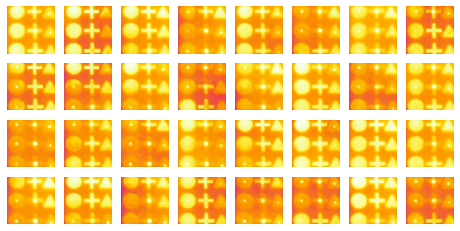

Epoch 42/400


100%|██████████| 228/228 [00:56<00:00,  4.04it/s]


Dis: loss= 0.5785, mae= 0.3573, acc= 0.7174
GAN: loss= 1.6897, mae= 0.7152, acc= 0.1868
Epoch 43/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.5576, mae= 0.3590, acc= 0.7357
GAN: loss= 1.5316, mae= 0.6916, acc= 0.1891
Epoch 44/400


100%|██████████| 228/228 [00:57<00:00,  4.00it/s]


Dis: loss= 0.5748, mae= 0.3391, acc= 0.7386
GAN: loss= 1.8307, mae= 0.7090, acc= 0.2005
Epoch 45/400


100%|██████████| 228/228 [00:57<00:00,  4.00it/s]


Dis: loss= 0.4970, mae= 0.3133, acc= 0.7697
GAN: loss= 2.1954, mae= 0.7773, acc= 0.1277
Epoch 46/400


100%|██████████| 228/228 [00:56<00:00,  4.03it/s]


Dis: loss= 0.4722, mae= 0.2991, acc= 0.7897
GAN: loss= 2.5851, mae= 0.8190, acc= 0.0995
Epoch 47/400


100%|██████████| 228/228 [00:57<00:00,  3.98it/s]


Dis: loss= 0.4769, mae= 0.2730, acc= 0.8041
GAN: loss= 2.7832, mae= 0.8058, acc= 0.1192
Epoch 48/400


100%|██████████| 228/228 [00:56<00:00,  4.00it/s]


Dis: loss= 0.4329, mae= 0.2560, acc= 0.8085
GAN: loss= 2.9055, mae= 0.8223, acc= 0.1066
Epoch 49/400


100%|██████████| 228/228 [00:57<00:00,  4.00it/s]


Dis: loss= 0.5387, mae= 0.3191, acc= 0.7641
GAN: loss= 2.0387, mae= 0.7513, acc= 0.1609
Epoch 50/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5165, mae= 0.2794, acc= 0.7878
GAN: loss= 2.8015, mae= 0.8034, acc= 0.1235
Epoch 51/400


100%|██████████| 228/228 [00:56<00:00,  4.06it/s]


Dis: loss= 0.4509, mae= 0.2810, acc= 0.7936
GAN: loss= 2.4589, mae= 0.7971, acc= 0.1168
Epoch 52/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.4696, mae= 0.2837, acc= 0.7871
GAN: loss= 2.8368, mae= 0.8306, acc= 0.0946
Epoch 53/400


100%|██████████| 228/228 [00:56<00:00,  4.06it/s]


Dis: loss= 0.5480, mae= 0.3220, acc= 0.7512
GAN: loss= 2.1276, mae= 0.7604, acc= 0.1390
Epoch 54/400


100%|██████████| 228/228 [00:56<00:00,  4.04it/s]


Dis: loss= 0.5275, mae= 0.3061, acc= 0.7560
GAN: loss= 2.3972, mae= 0.7706, acc= 0.1565
Epoch 55/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.4928, mae= 0.2795, acc= 0.7934
GAN: loss= 2.2877, mae= 0.7877, acc= 0.1181
Epoch 56/400


100%|██████████| 228/228 [00:56<00:00,  4.04it/s]


Dis: loss= 0.5663, mae= 0.3592, acc= 0.7209
GAN: loss= 1.6050, mae= 0.7034, acc= 0.1763
Epoch 57/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5248, mae= 0.2579, acc= 0.8048
GAN: loss= 2.9172, mae= 0.8144, acc= 0.1231
Epoch 58/400


100%|██████████| 228/228 [00:56<00:00,  4.00it/s]


Dis: loss= 0.5006, mae= 0.3213, acc= 0.7672
GAN: loss= 1.8554, mae= 0.7562, acc= 0.1298
Epoch 59/400


100%|██████████| 228/228 [00:56<00:00,  4.06it/s]


Dis: loss= 0.5676, mae= 0.3339, acc= 0.7387
GAN: loss= 2.0056, mae= 0.7492, acc= 0.1612
Epoch 60/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5605, mae= 0.3113, acc= 0.7724
GAN: loss= 2.1136, mae= 0.7475, acc= 0.1639
Epoch 61/400


100%|██████████| 228/228 [00:56<00:00,  4.00it/s]


Dis: loss= 0.5718, mae= 0.3306, acc= 0.7715
GAN: loss= 1.8460, mae= 0.7284, acc= 0.1580


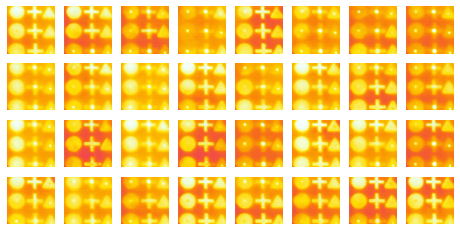

Epoch 62/400


100%|██████████| 228/228 [00:56<00:00,  4.04it/s]


Dis: loss= 0.5368, mae= 0.3283, acc= 0.7652
GAN: loss= 1.8650, mae= 0.7310, acc= 0.1582
Epoch 63/400


100%|██████████| 228/228 [00:56<00:00,  4.06it/s]


Dis: loss= 0.5736, mae= 0.3579, acc= 0.7275
GAN: loss= 1.6555, mae= 0.7086, acc= 0.1870
Epoch 64/400


100%|██████████| 228/228 [00:56<00:00,  4.05it/s]


Dis: loss= 0.5691, mae= 0.3465, acc= 0.7355
GAN: loss= 1.8597, mae= 0.7374, acc= 0.1669
Epoch 65/400


100%|██████████| 228/228 [00:57<00:00,  4.00it/s]


Dis: loss= 0.5530, mae= 0.3194, acc= 0.7721
GAN: loss= 1.9651, mae= 0.7512, acc= 0.1314
Epoch 66/400


100%|██████████| 228/228 [00:57<00:00,  3.99it/s]


Dis: loss= 0.5129, mae= 0.3096, acc= 0.7827
GAN: loss= 2.1068, mae= 0.7724, acc= 0.1284
Epoch 67/400


100%|██████████| 228/228 [00:56<00:00,  4.00it/s]


Dis: loss= 0.5653, mae= 0.3350, acc= 0.7358
GAN: loss= 1.8292, mae= 0.7245, acc= 0.1809
Epoch 68/400


100%|██████████| 228/228 [00:56<00:00,  4.05it/s]


Dis: loss= 0.5443, mae= 0.3030, acc= 0.7758
GAN: loss= 2.3196, mae= 0.7697, acc= 0.1338
Epoch 69/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.4859, mae= 0.3160, acc= 0.7746
GAN: loss= 1.9182, mae= 0.7491, acc= 0.1456
Epoch 70/400


100%|██████████| 228/228 [00:56<00:00,  4.05it/s]


Dis: loss= 0.5335, mae= 0.3227, acc= 0.7378
GAN: loss= 2.2441, mae= 0.7565, acc= 0.1620
Epoch 71/400


100%|██████████| 228/228 [00:56<00:00,  4.03it/s]


Dis: loss= 0.6087, mae= 0.3083, acc= 0.7853
GAN: loss= 2.1680, mae= 0.7545, acc= 0.1509
Epoch 72/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.5664, mae= 0.3483, acc= 0.7273
GAN: loss= 2.0637, mae= 0.7306, acc= 0.1737
Epoch 73/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.3875, mae= 0.2363, acc= 0.8357
GAN: loss= 2.7157, mae= 0.7789, acc= 0.1495
Epoch 74/400


100%|██████████| 228/228 [00:57<00:00,  3.99it/s]


Dis: loss= 0.5315, mae= 0.3135, acc= 0.7699
GAN: loss= 2.1313, mae= 0.7758, acc= 0.1284
Epoch 75/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.5778, mae= 0.3288, acc= 0.7595
GAN: loss= 1.8303, mae= 0.7243, acc= 0.1600
Epoch 76/400


100%|██████████| 228/228 [00:56<00:00,  4.03it/s]


Dis: loss= 0.5146, mae= 0.3349, acc= 0.7536
GAN: loss= 1.7003, mae= 0.7243, acc= 0.1641
Epoch 77/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.5423, mae= 0.3278, acc= 0.7464
GAN: loss= 1.9901, mae= 0.7544, acc= 0.1409
Epoch 78/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5276, mae= 0.2997, acc= 0.7686
GAN: loss= 2.5796, mae= 0.8033, acc= 0.1136
Epoch 79/400


100%|██████████| 228/228 [00:57<00:00,  3.97it/s]


Dis: loss= 0.5294, mae= 0.3131, acc= 0.7658
GAN: loss= 1.8706, mae= 0.7350, acc= 0.1705
Epoch 80/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5603, mae= 0.3132, acc= 0.7557
GAN: loss= 2.4184, mae= 0.7522, acc= 0.1682
Epoch 81/400


100%|██████████| 228/228 [00:57<00:00,  3.99it/s]


Dis: loss= 0.3428, mae= 0.2129, acc= 0.8573
GAN: loss= 2.6533, mae= 0.7633, acc= 0.1634


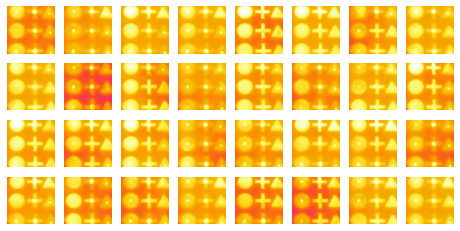

Epoch 82/400


100%|██████████| 228/228 [00:56<00:00,  4.03it/s]


Dis: loss= 0.5430, mae= 0.3460, acc= 0.7309
GAN: loss= 1.7115, mae= 0.7027, acc= 0.2053
Epoch 83/400


100%|██████████| 228/228 [00:57<00:00,  3.99it/s]


Dis: loss= 0.4954, mae= 0.2920, acc= 0.7764
GAN: loss= 2.3152, mae= 0.7538, acc= 0.1775
Epoch 84/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5124, mae= 0.2988, acc= 0.7719
GAN: loss= 2.3851, mae= 0.7759, acc= 0.1542
Epoch 85/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.4564, mae= 0.2893, acc= 0.8019
GAN: loss= 2.1316, mae= 0.7795, acc= 0.1297
Epoch 86/400


100%|██████████| 228/228 [00:57<00:00,  3.98it/s]


Dis: loss= 0.5268, mae= 0.3027, acc= 0.7630
GAN: loss= 2.1763, mae= 0.7507, acc= 0.1721
Epoch 87/400


100%|██████████| 228/228 [00:57<00:00,  3.98it/s]


Dis: loss= 0.5814, mae= 0.3277, acc= 0.7569
GAN: loss= 1.9040, mae= 0.7254, acc= 0.1802
Epoch 88/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.4959, mae= 0.3072, acc= 0.7831
GAN: loss= 1.9667, mae= 0.7610, acc= 0.1434
Epoch 89/400


100%|██████████| 228/228 [00:56<00:00,  4.00it/s]


Dis: loss= 0.6282, mae= 0.3361, acc= 0.7294
GAN: loss= 2.0580, mae= 0.7321, acc= 0.1859
Epoch 90/400


100%|██████████| 228/228 [00:57<00:00,  3.98it/s]


Dis: loss= 0.5236, mae= 0.3077, acc= 0.7886
GAN: loss= 1.7963, mae= 0.7325, acc= 0.1658
Epoch 91/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.5285, mae= 0.3238, acc= 0.7499
GAN: loss= 1.9663, mae= 0.7480, acc= 0.1584
Epoch 92/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.5345, mae= 0.3349, acc= 0.7305
GAN: loss= 1.9869, mae= 0.7550, acc= 0.1524
Epoch 93/400


100%|██████████| 228/228 [00:57<00:00,  4.00it/s]


Dis: loss= 0.5022, mae= 0.2942, acc= 0.7743
GAN: loss= 2.3046, mae= 0.7650, acc= 0.1630
Epoch 94/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5687, mae= 0.3419, acc= 0.7405
GAN: loss= 1.7730, mae= 0.7244, acc= 0.1789
Epoch 95/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.5519, mae= 0.3296, acc= 0.7577
GAN: loss= 1.8965, mae= 0.7360, acc= 0.1598
Epoch 96/400


100%|██████████| 228/228 [00:57<00:00,  3.98it/s]


Dis: loss= 0.5563, mae= 0.3301, acc= 0.7575
GAN: loss= 1.8704, mae= 0.7258, acc= 0.1760
Epoch 97/400


100%|██████████| 228/228 [00:57<00:00,  3.97it/s]


Dis: loss= 0.5492, mae= 0.3251, acc= 0.7485
GAN: loss= 2.1611, mae= 0.7250, acc= 0.1849
Epoch 98/400


100%|██████████| 228/228 [00:57<00:00,  3.97it/s]


Dis: loss= 0.5155, mae= 0.3368, acc= 0.7560
GAN: loss= 1.6318, mae= 0.7220, acc= 0.1542
Epoch 99/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5718, mae= 0.3142, acc= 0.7709
GAN: loss= 2.0526, mae= 0.7534, acc= 0.1465
Epoch 100/400


100%|██████████| 228/228 [00:57<00:00,  4.00it/s]


Dis: loss= 0.5513, mae= 0.3315, acc= 0.7463
GAN: loss= 1.8738, mae= 0.7218, acc= 0.1835
Epoch 101/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5373, mae= 0.3308, acc= 0.7506
GAN: loss= 1.9032, mae= 0.7529, acc= 0.1443


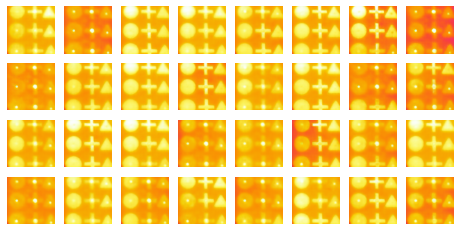

Epoch 102/400


100%|██████████| 228/228 [00:57<00:00,  3.99it/s]


Dis: loss= 0.5067, mae= 0.3117, acc= 0.7626
GAN: loss= 2.0898, mae= 0.7655, acc= 0.1478
Epoch 103/400


100%|██████████| 228/228 [00:56<00:00,  4.04it/s]


Dis: loss= 0.5625, mae= 0.3284, acc= 0.7479
GAN: loss= 1.9433, mae= 0.7387, acc= 0.1664
Epoch 104/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.6057, mae= 0.3791, acc= 0.6957
GAN: loss= 1.5387, mae= 0.6837, acc= 0.2204
Epoch 105/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5544, mae= 0.3446, acc= 0.7418
GAN: loss= 1.7417, mae= 0.7004, acc= 0.1927
Epoch 106/400


100%|██████████| 228/228 [00:57<00:00,  3.99it/s]


Dis: loss= 0.6247, mae= 0.3677, acc= 0.7096
GAN: loss= 1.5851, mae= 0.6853, acc= 0.2086
Epoch 107/400


100%|██████████| 228/228 [00:57<00:00,  3.98it/s]


Dis: loss= 0.5934, mae= 0.3480, acc= 0.7444
GAN: loss= 1.5978, mae= 0.6995, acc= 0.1885
Epoch 108/400


100%|██████████| 228/228 [00:56<00:00,  4.00it/s]


Dis: loss= 0.6315, mae= 0.4100, acc= 0.6669
GAN: loss= 1.3226, mae= 0.6613, acc= 0.2144
Epoch 109/400


100%|██████████| 228/228 [00:56<00:00,  4.00it/s]


Dis: loss= 0.5699, mae= 0.3601, acc= 0.7233
GAN: loss= 1.4139, mae= 0.6669, acc= 0.2351
Epoch 110/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5008, mae= 0.3186, acc= 0.7630
GAN: loss= 1.9377, mae= 0.7349, acc= 0.1689
Epoch 111/400


100%|██████████| 228/228 [00:56<00:00,  4.04it/s]


Dis: loss= 0.5612, mae= 0.3477, acc= 0.7217
GAN: loss= 1.8549, mae= 0.7230, acc= 0.1924
Epoch 112/400


100%|██████████| 228/228 [00:56<00:00,  4.04it/s]


Dis: loss= 0.6577, mae= 0.3612, acc= 0.7282
GAN: loss= 1.6580, mae= 0.6703, acc= 0.2244
Epoch 113/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5423, mae= 0.3508, acc= 0.7484
GAN: loss= 1.5830, mae= 0.7126, acc= 0.1608
Epoch 114/400


100%|██████████| 228/228 [00:56<00:00,  4.06it/s]


Dis: loss= 0.4995, mae= 0.3113, acc= 0.7754
GAN: loss= 2.0350, mae= 0.7656, acc= 0.1264
Epoch 115/400


100%|██████████| 228/228 [00:56<00:00,  4.04it/s]


Dis: loss= 0.5317, mae= 0.3221, acc= 0.7654
GAN: loss= 1.9620, mae= 0.7486, acc= 0.1516
Epoch 116/400


100%|██████████| 228/228 [00:56<00:00,  4.02it/s]


Dis: loss= 0.5921, mae= 0.3714, acc= 0.6972
GAN: loss= 1.5123, mae= 0.6862, acc= 0.2075
Epoch 117/400


100%|██████████| 228/228 [00:56<00:00,  4.05it/s]


Dis: loss= 0.5849, mae= 0.3578, acc= 0.7288
GAN: loss= 1.5690, mae= 0.6899, acc= 0.2002
Epoch 118/400


100%|██████████| 228/228 [00:56<00:00,  4.03it/s]


Dis: loss= 0.5801, mae= 0.3438, acc= 0.7546
GAN: loss= 1.5975, mae= 0.6884, acc= 0.1904
Epoch 119/400


100%|██████████| 228/228 [00:56<00:00,  4.05it/s]


Dis: loss= 0.5780, mae= 0.3532, acc= 0.7317
GAN: loss= 1.6357, mae= 0.6951, acc= 0.2059
Epoch 120/400


100%|██████████| 228/228 [00:56<00:00,  4.06it/s]


Dis: loss= 0.5814, mae= 0.3620, acc= 0.7082
GAN: loss= 1.7521, mae= 0.7134, acc= 0.1820
Epoch 121/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5326, mae= 0.3315, acc= 0.7543
GAN: loss= 1.6947, mae= 0.7213, acc= 0.1689


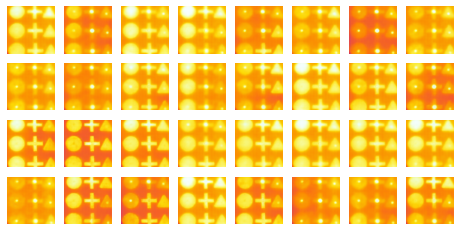

Epoch 122/400


100%|██████████| 228/228 [00:57<00:00,  4.00it/s]


Dis: loss= 0.5781, mae= 0.3590, acc= 0.7255
GAN: loss= 1.5462, mae= 0.6908, acc= 0.1954
Epoch 123/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5847, mae= 0.3407, acc= 0.7401
GAN: loss= 1.8661, mae= 0.7264, acc= 0.1717
Epoch 124/400


100%|██████████| 228/228 [00:57<00:00,  3.99it/s]


Dis: loss= 0.5572, mae= 0.3534, acc= 0.7327
GAN: loss= 1.5473, mae= 0.6974, acc= 0.1897
Epoch 125/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5641, mae= 0.3528, acc= 0.7223
GAN: loss= 1.6894, mae= 0.7157, acc= 0.1793
Epoch 126/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5731, mae= 0.3514, acc= 0.7171
GAN: loss= 1.6412, mae= 0.7016, acc= 0.2042
Epoch 127/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5824, mae= 0.3665, acc= 0.7157
GAN: loss= 1.4887, mae= 0.6813, acc= 0.2116
Epoch 128/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.5428, mae= 0.3224, acc= 0.7459
GAN: loss= 2.0125, mae= 0.6684, acc= 0.2765
Epoch 129/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5707, mae= 0.3465, acc= 0.7382
GAN: loss= 1.5571, mae= 0.6842, acc= 0.2066
Epoch 130/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.6053, mae= 0.3485, acc= 0.7490
GAN: loss= 1.8206, mae= 0.7062, acc= 0.1750
Epoch 131/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5307, mae= 0.3430, acc= 0.7460
GAN: loss= 1.6108, mae= 0.7041, acc= 0.1902
Epoch 132/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5513, mae= 0.3436, acc= 0.7360
GAN: loss= 1.7606, mae= 0.7267, acc= 0.1682
Epoch 133/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5921, mae= 0.3542, acc= 0.7089
GAN: loss= 1.8113, mae= 0.7118, acc= 0.1982
Epoch 134/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5128, mae= 0.3179, acc= 0.7688
GAN: loss= 1.7292, mae= 0.7134, acc= 0.1976
Epoch 135/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5131, mae= 0.3313, acc= 0.7636
GAN: loss= 1.7624, mae= 0.7255, acc= 0.1525
Epoch 136/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5847, mae= 0.3527, acc= 0.7226
GAN: loss= 1.6589, mae= 0.7031, acc= 0.2005
Epoch 137/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.6238, mae= 0.3600, acc= 0.7102
GAN: loss= 1.6171, mae= 0.6875, acc= 0.2253
Epoch 138/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5574, mae= 0.3743, acc= 0.7167
GAN: loss= 1.3509, mae= 0.6761, acc= 0.1852
Epoch 139/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5639, mae= 0.3650, acc= 0.7145
GAN: loss= 1.4055, mae= 0.6741, acc= 0.2071
Epoch 140/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5906, mae= 0.3623, acc= 0.7105
GAN: loss= 1.4484, mae= 0.6644, acc= 0.2381
Epoch 141/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5546, mae= 0.3293, acc= 0.7442
GAN: loss= 1.8780, mae= 0.7368, acc= 0.1680


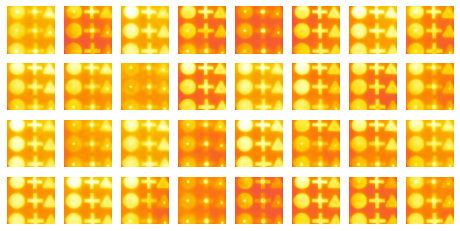

Epoch 142/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5225, mae= 0.3180, acc= 0.7746
GAN: loss= 1.9485, mae= 0.7332, acc= 0.1550
Epoch 143/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.4589, mae= 0.2702, acc= 0.7999
GAN: loss= 2.1110, mae= 0.7396, acc= 0.1878
Epoch 144/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5427, mae= 0.3282, acc= 0.7486
GAN: loss= 1.7692, mae= 0.7216, acc= 0.1806
Epoch 145/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.6184, mae= 0.3534, acc= 0.7340
GAN: loss= 1.6377, mae= 0.6983, acc= 0.2057
Epoch 146/400


100%|██████████| 228/228 [00:57<00:00,  3.97it/s]


Dis: loss= 0.5460, mae= 0.3330, acc= 0.7460
GAN: loss= 1.7939, mae= 0.7268, acc= 0.1732
Epoch 147/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5370, mae= 0.3425, acc= 0.7416
GAN: loss= 1.7330, mae= 0.7227, acc= 0.1675
Epoch 148/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5650, mae= 0.3667, acc= 0.7243
GAN: loss= 1.5201, mae= 0.6913, acc= 0.1926
Epoch 149/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5424, mae= 0.3310, acc= 0.7444
GAN: loss= 1.8437, mae= 0.7336, acc= 0.1619
Epoch 150/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.6079, mae= 0.3561, acc= 0.7308
GAN: loss= 1.6477, mae= 0.7022, acc= 0.1919
Epoch 151/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5294, mae= 0.3332, acc= 0.7464
GAN: loss= 1.6705, mae= 0.7059, acc= 0.1961
Epoch 152/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5636, mae= 0.3285, acc= 0.7397
GAN: loss= 1.9204, mae= 0.7174, acc= 0.1923
Epoch 153/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5479, mae= 0.3497, acc= 0.7194
GAN: loss= 1.6738, mae= 0.6974, acc= 0.2055
Epoch 154/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.6180, mae= 0.3940, acc= 0.6713
GAN: loss= 1.3442, mae= 0.6543, acc= 0.2479
Epoch 155/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5496, mae= 0.3425, acc= 0.7392
GAN: loss= 1.6186, mae= 0.6985, acc= 0.2035
Epoch 156/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5670, mae= 0.3652, acc= 0.7102
GAN: loss= 1.5296, mae= 0.6844, acc= 0.2149
Epoch 157/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.6369, mae= 0.3641, acc= 0.7196
GAN: loss= 1.6082, mae= 0.6884, acc= 0.2103
Epoch 158/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5492, mae= 0.3580, acc= 0.7220
GAN: loss= 1.5944, mae= 0.7026, acc= 0.1875
Epoch 159/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.6076, mae= 0.3893, acc= 0.6879
GAN: loss= 1.3002, mae= 0.6477, acc= 0.2403
Epoch 160/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5480, mae= 0.3384, acc= 0.7381
GAN: loss= 1.6818, mae= 0.7043, acc= 0.1898
Epoch 161/400


100%|██████████| 228/228 [00:57<00:00,  3.97it/s]


Dis: loss= 0.5673, mae= 0.3204, acc= 0.7573
GAN: loss= 1.8801, mae= 0.7209, acc= 0.1886


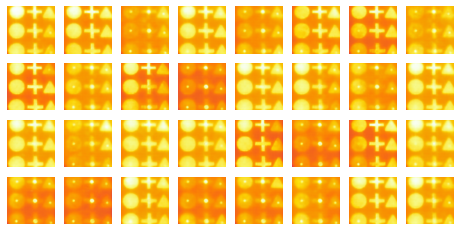

Epoch 162/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5755, mae= 0.3554, acc= 0.7216
GAN: loss= 1.5507, mae= 0.6881, acc= 0.2141
Epoch 163/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5859, mae= 0.3714, acc= 0.7054
GAN: loss= 1.4140, mae= 0.6674, acc= 0.2293
Epoch 164/400


100%|██████████| 228/228 [00:57<00:00,  3.98it/s]


Dis: loss= 0.5446, mae= 0.3421, acc= 0.7397
GAN: loss= 1.6849, mae= 0.7131, acc= 0.1808
Epoch 165/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.4911, mae= 0.2718, acc= 0.7980
GAN: loss= 2.4917, mae= 0.7697, acc= 0.1552
Epoch 166/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5153, mae= 0.3254, acc= 0.7540
GAN: loss= 1.8878, mae= 0.7323, acc= 0.1758
Epoch 167/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5994, mae= 0.3570, acc= 0.7179
GAN: loss= 1.5821, mae= 0.6819, acc= 0.2246
Epoch 168/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5834, mae= 0.3631, acc= 0.7312
GAN: loss= 1.3943, mae= 0.6651, acc= 0.2104
Epoch 169/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5916, mae= 0.3752, acc= 0.7076
GAN: loss= 1.3867, mae= 0.6697, acc= 0.2174
Epoch 170/400


100%|██████████| 228/228 [00:57<00:00,  3.98it/s]


Dis: loss= 0.6127, mae= 0.3915, acc= 0.6785
GAN: loss= 1.3724, mae= 0.6655, acc= 0.2212
Epoch 171/400


100%|██████████| 228/228 [00:57<00:00,  3.98it/s]


Dis: loss= 0.6009, mae= 0.3844, acc= 0.6952
GAN: loss= 1.3835, mae= 0.6684, acc= 0.2214
Epoch 172/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5655, mae= 0.3361, acc= 0.7582
GAN: loss= 1.6647, mae= 0.7075, acc= 0.1820
Epoch 173/400


100%|██████████| 228/228 [00:57<00:00,  3.98it/s]


Dis: loss= 0.5798, mae= 0.3590, acc= 0.7292
GAN: loss= 1.5736, mae= 0.6786, acc= 0.2155
Epoch 174/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5339, mae= 0.3371, acc= 0.7392
GAN: loss= 1.7215, mae= 0.7224, acc= 0.1735
Epoch 175/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5645, mae= 0.3239, acc= 0.7391
GAN: loss= 2.0639, mae= 0.7297, acc= 0.1942
Epoch 176/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5321, mae= 0.3509, acc= 0.7382
GAN: loss= 1.3961, mae= 0.6659, acc= 0.2266
Epoch 177/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5179, mae= 0.3287, acc= 0.7629
GAN: loss= 1.7237, mae= 0.7182, acc= 0.1787
Epoch 178/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5674, mae= 0.3431, acc= 0.7444
GAN: loss= 1.6467, mae= 0.7059, acc= 0.1768
Epoch 179/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.6016, mae= 0.3657, acc= 0.6987
GAN: loss= 1.7201, mae= 0.7134, acc= 0.1935
Epoch 180/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.4922, mae= 0.3169, acc= 0.7630
GAN: loss= 1.8763, mae= 0.7444, acc= 0.1578
Epoch 181/400


100%|██████████| 228/228 [00:57<00:00,  4.00it/s]


Dis: loss= 0.5587, mae= 0.3344, acc= 0.7425
GAN: loss= 1.8407, mae= 0.7212, acc= 0.1886


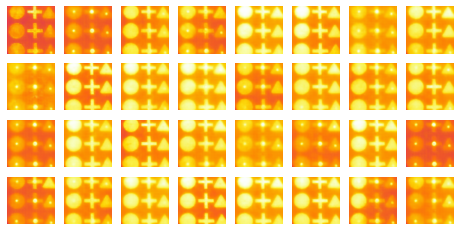

Epoch 182/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.6373, mae= 0.3577, acc= 0.7251
GAN: loss= 1.6441, mae= 0.6763, acc= 0.2242
Epoch 183/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5617, mae= 0.3521, acc= 0.7322
GAN: loss= 1.5244, mae= 0.6795, acc= 0.2215
Epoch 184/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5397, mae= 0.3503, acc= 0.7479
GAN: loss= 1.4880, mae= 0.6929, acc= 0.1916
Epoch 185/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5964, mae= 0.3684, acc= 0.6957
GAN: loss= 1.5882, mae= 0.6960, acc= 0.2030
Epoch 186/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5375, mae= 0.3168, acc= 0.7645
GAN: loss= 2.0106, mae= 0.7357, acc= 0.1695
Epoch 187/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5631, mae= 0.3435, acc= 0.7283
GAN: loss= 1.7024, mae= 0.7065, acc= 0.2066
Epoch 188/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.5476, mae= 0.3354, acc= 0.7335
GAN: loss= 1.8723, mae= 0.7360, acc= 0.1689
Epoch 189/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.4410, mae= 0.2728, acc= 0.7988
GAN: loss= 2.1663, mae= 0.7675, acc= 0.1480
Epoch 190/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.6484, mae= 0.3589, acc= 0.7225
GAN: loss= 1.7767, mae= 0.6968, acc= 0.1975
Epoch 191/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.7018, mae= 0.3678, acc= 0.7046
GAN: loss= 1.7198, mae= 0.6760, acc= 0.2381
Epoch 192/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5415, mae= 0.3423, acc= 0.7508
GAN: loss= 1.6823, mae= 0.7060, acc= 0.1827
Epoch 193/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5737, mae= 0.3538, acc= 0.7221
GAN: loss= 1.7765, mae= 0.7185, acc= 0.1743
Epoch 194/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5208, mae= 0.3153, acc= 0.7529
GAN: loss= 2.0216, mae= 0.7431, acc= 0.1837
Epoch 195/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5791, mae= 0.3665, acc= 0.7012
GAN: loss= 1.5098, mae= 0.6827, acc= 0.2179
Epoch 196/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5967, mae= 0.3730, acc= 0.7083
GAN: loss= 1.5406, mae= 0.6865, acc= 0.2148
Epoch 197/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5864, mae= 0.3144, acc= 0.7553
GAN: loss= 2.0083, mae= 0.7353, acc= 0.1822
Epoch 198/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5579, mae= 0.3716, acc= 0.7164
GAN: loss= 1.3859, mae= 0.6667, acc= 0.2148
Epoch 199/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5946, mae= 0.3801, acc= 0.6942
GAN: loss= 1.4008, mae= 0.6637, acc= 0.2286
Epoch 200/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.5778, mae= 0.3503, acc= 0.7178
GAN: loss= 1.6962, mae= 0.7028, acc= 0.2033
Epoch 201/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5057, mae= 0.3156, acc= 0.7563
GAN: loss= 1.9371, mae= 0.7464, acc= 0.1610


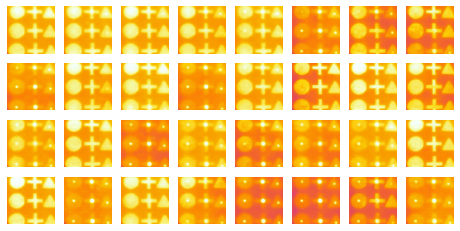

Epoch 202/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5317, mae= 0.3164, acc= 0.7621
GAN: loss= 1.8772, mae= 0.7247, acc= 0.1909
Epoch 203/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.5342, mae= 0.3287, acc= 0.7469
GAN: loss= 1.7560, mae= 0.7093, acc= 0.2048
Epoch 204/400


100%|██████████| 228/228 [00:57<00:00,  3.98it/s]


Dis: loss= 0.4759, mae= 0.2964, acc= 0.7773
GAN: loss= 2.0535, mae= 0.7555, acc= 0.1516
Epoch 205/400


100%|██████████| 228/228 [00:57<00:00,  3.99it/s]


Dis: loss= 0.5248, mae= 0.3229, acc= 0.7442
GAN: loss= 1.8813, mae= 0.7381, acc= 0.1723
Epoch 206/400


100%|██████████| 228/228 [00:57<00:00,  3.97it/s]


Dis: loss= 0.5230, mae= 0.3221, acc= 0.7518
GAN: loss= 1.8325, mae= 0.7320, acc= 0.1767
Epoch 207/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.5757, mae= 0.3428, acc= 0.7397
GAN: loss= 1.6509, mae= 0.6993, acc= 0.2053
Epoch 208/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5766, mae= 0.3788, acc= 0.7059
GAN: loss= 1.3302, mae= 0.6584, acc= 0.2307
Epoch 209/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.6081, mae= 0.3780, acc= 0.6928
GAN: loss= 1.4354, mae= 0.6597, acc= 0.2534
Epoch 210/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5670, mae= 0.3484, acc= 0.7318
GAN: loss= 1.6303, mae= 0.7001, acc= 0.1952
Epoch 211/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.7105, mae= 0.3233, acc= 0.7553
GAN: loss= 2.3101, mae= 0.7320, acc= 0.1824
Epoch 212/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5436, mae= 0.3529, acc= 0.7279
GAN: loss= 1.5271, mae= 0.6858, acc= 0.2118
Epoch 213/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5386, mae= 0.3215, acc= 0.7719
GAN: loss= 1.9797, mae= 0.7345, acc= 0.1628
Epoch 214/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5510, mae= 0.3317, acc= 0.7547
GAN: loss= 1.9238, mae= 0.7321, acc= 0.1623
Epoch 215/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.6161, mae= 0.3748, acc= 0.7101
GAN: loss= 1.4471, mae= 0.6669, acc= 0.2160
Epoch 216/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5918, mae= 0.3802, acc= 0.6984
GAN: loss= 1.4158, mae= 0.6687, acc= 0.2311
Epoch 217/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5810, mae= 0.3768, acc= 0.7110
GAN: loss= 1.3524, mae= 0.6545, acc= 0.2334
Epoch 218/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5286, mae= 0.3392, acc= 0.7411
GAN: loss= 1.7361, mae= 0.7244, acc= 0.1691
Epoch 219/400


100%|██████████| 228/228 [00:57<00:00,  3.97it/s]


Dis: loss= 0.5640, mae= 0.3161, acc= 0.7458
GAN: loss= 2.1167, mae= 0.7569, acc= 0.1627
Epoch 220/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5479, mae= 0.3371, acc= 0.7300
GAN: loss= 1.7420, mae= 0.7090, acc= 0.2035
Epoch 221/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.4829, mae= 0.2860, acc= 0.7816
GAN: loss= 2.3021, mae= 0.7647, acc= 0.1564


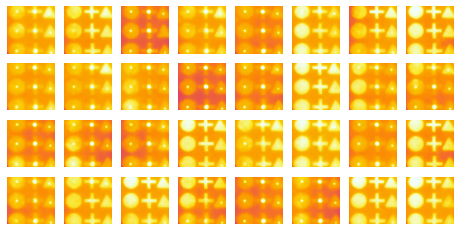

Epoch 222/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5355, mae= 0.3070, acc= 0.7485
GAN: loss= 2.2559, mae= 0.7530, acc= 0.1741
Epoch 223/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5205, mae= 0.3197, acc= 0.7533
GAN: loss= 1.9551, mae= 0.7390, acc= 0.1732
Epoch 224/400


100%|██████████| 228/228 [00:57<00:00,  3.99it/s]


Dis: loss= 0.5377, mae= 0.3322, acc= 0.7415
GAN: loss= 1.8836, mae= 0.7174, acc= 0.1831
Epoch 225/400


100%|██████████| 228/228 [00:56<00:00,  4.01it/s]


Dis: loss= 0.5195, mae= 0.3422, acc= 0.7401
GAN: loss= 1.6305, mae= 0.7135, acc= 0.1700
Epoch 226/400


100%|██████████| 228/228 [01:21<00:00,  2.78it/s]


Dis: loss= 0.5957, mae= 0.3629, acc= 0.7065
GAN: loss= 1.5820, mae= 0.6852, acc= 0.2227
Epoch 227/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5814, mae= 0.3428, acc= 0.7325
GAN: loss= 1.9093, mae= 0.7222, acc= 0.1853
Epoch 228/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5528, mae= 0.3626, acc= 0.7213
GAN: loss= 1.5297, mae= 0.6852, acc= 0.2037
Epoch 229/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.5912, mae= 0.3342, acc= 0.7416
GAN: loss= 1.7801, mae= 0.7099, acc= 0.1859
Epoch 230/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5193, mae= 0.3340, acc= 0.7551
GAN: loss= 1.6535, mae= 0.7107, acc= 0.1834
Epoch 231/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.5816, mae= 0.3165, acc= 0.7570
GAN: loss= 2.1716, mae= 0.7461, acc= 0.1665
Epoch 232/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.6377, mae= 0.3891, acc= 0.6773
GAN: loss= 1.4316, mae= 0.6625, acc= 0.2394
Epoch 233/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5172, mae= 0.3181, acc= 0.7680
GAN: loss= 1.9056, mae= 0.7371, acc= 0.1516
Epoch 234/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.6269, mae= 0.3931, acc= 0.6802
GAN: loss= 1.3668, mae= 0.6562, acc= 0.2400
Epoch 235/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5273, mae= 0.3168, acc= 0.7589
GAN: loss= 1.8133, mae= 0.7045, acc= 0.2175
Epoch 236/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5582, mae= 0.3446, acc= 0.7366
GAN: loss= 1.6398, mae= 0.7050, acc= 0.1956
Epoch 237/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5641, mae= 0.3224, acc= 0.7566
GAN: loss= 1.8550, mae= 0.7314, acc= 0.1704
Epoch 238/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5199, mae= 0.3310, acc= 0.7545
GAN: loss= 1.7318, mae= 0.7084, acc= 0.1935
Epoch 239/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5716, mae= 0.3482, acc= 0.7223
GAN: loss= 1.8095, mae= 0.7192, acc= 0.1983
Epoch 240/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5814, mae= 0.3440, acc= 0.7238
GAN: loss= 1.9121, mae= 0.7257, acc= 0.1891
Epoch 241/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5245, mae= 0.3270, acc= 0.7503
GAN: loss= 1.7927, mae= 0.7294, acc= 0.1763


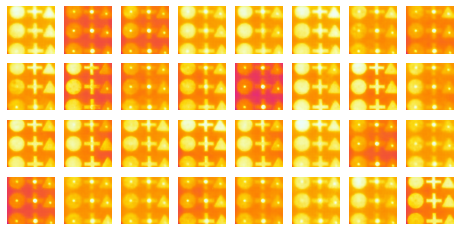

Epoch 242/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5713, mae= 0.3525, acc= 0.7325
GAN: loss= 1.5633, mae= 0.6873, acc= 0.2078
Epoch 243/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5697, mae= 0.3560, acc= 0.7212
GAN: loss= 1.6179, mae= 0.6891, acc= 0.2093
Epoch 244/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5515, mae= 0.3468, acc= 0.7333
GAN: loss= 1.6281, mae= 0.7030, acc= 0.1935
Epoch 245/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5669, mae= 0.3355, acc= 0.7280
GAN: loss= 1.8316, mae= 0.7134, acc= 0.2112
Epoch 246/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5705, mae= 0.3637, acc= 0.7157
GAN: loss= 1.4871, mae= 0.6808, acc= 0.2183
Epoch 247/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.6057, mae= 0.3531, acc= 0.7064
GAN: loss= 1.7982, mae= 0.6925, acc= 0.2267
Epoch 248/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.4847, mae= 0.2868, acc= 0.7802
GAN: loss= 2.4188, mae= 0.7759, acc= 0.1498
Epoch 249/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5403, mae= 0.3500, acc= 0.7397
GAN: loss= 1.4830, mae= 0.6760, acc= 0.2185
Epoch 250/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5864, mae= 0.3590, acc= 0.7081
GAN: loss= 1.5616, mae= 0.6893, acc= 0.2189
Epoch 251/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5830, mae= 0.3641, acc= 0.7233
GAN: loss= 1.5414, mae= 0.6892, acc= 0.1908
Epoch 252/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5730, mae= 0.3673, acc= 0.7155
GAN: loss= 1.4386, mae= 0.6666, acc= 0.2303
Epoch 253/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5391, mae= 0.3265, acc= 0.7429
GAN: loss= 2.0822, mae= 0.7404, acc= 0.1768
Epoch 254/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5193, mae= 0.2991, acc= 0.7719
GAN: loss= 2.2243, mae= 0.7597, acc= 0.1626
Epoch 255/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5592, mae= 0.3240, acc= 0.7422
GAN: loss= 2.1473, mae= 0.7446, acc= 0.1735
Epoch 256/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5190, mae= 0.3145, acc= 0.7599
GAN: loss= 2.0180, mae= 0.7407, acc= 0.1637
Epoch 257/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5490, mae= 0.3285, acc= 0.7495
GAN: loss= 1.7827, mae= 0.7229, acc= 0.1857
Epoch 258/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5764, mae= 0.3587, acc= 0.7101
GAN: loss= 1.5868, mae= 0.6890, acc= 0.2190
Epoch 259/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.6004, mae= 0.3658, acc= 0.7061
GAN: loss= 1.5519, mae= 0.6809, acc= 0.2197
Epoch 260/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5895, mae= 0.3763, acc= 0.7020
GAN: loss= 1.4193, mae= 0.6697, acc= 0.2204
Epoch 261/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5232, mae= 0.3275, acc= 0.7561
GAN: loss= 1.7338, mae= 0.7188, acc= 0.1805


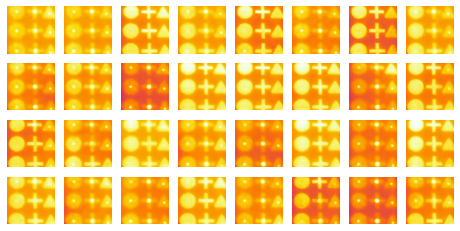

Epoch 262/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5917, mae= 0.3570, acc= 0.7177
GAN: loss= 1.6753, mae= 0.7119, acc= 0.1791
Epoch 263/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.5478, mae= 0.3534, acc= 0.7314
GAN: loss= 1.5482, mae= 0.6962, acc= 0.1976
Epoch 264/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.5011, mae= 0.3015, acc= 0.7729
GAN: loss= 2.0990, mae= 0.7488, acc= 0.1638
Epoch 265/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5810, mae= 0.3428, acc= 0.7216
GAN: loss= 1.9004, mae= 0.7283, acc= 0.1804
Epoch 266/400


100%|██████████| 228/228 [00:57<00:00,  3.96it/s]


Dis: loss= 0.5488, mae= 0.3221, acc= 0.7475
GAN: loss= 1.9655, mae= 0.7440, acc= 0.1654
Epoch 267/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5573, mae= 0.3582, acc= 0.7149
GAN: loss= 1.5662, mae= 0.6897, acc= 0.2129
Epoch 268/400


100%|██████████| 228/228 [00:57<00:00,  3.95it/s]


Dis: loss= 0.6175, mae= 0.3313, acc= 0.7406
GAN: loss= 1.8580, mae= 0.7137, acc= 0.1908
Epoch 269/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5928, mae= 0.3575, acc= 0.7061
GAN: loss= 1.7641, mae= 0.7014, acc= 0.2181
Epoch 270/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5303, mae= 0.3171, acc= 0.7447
GAN: loss= 1.9525, mae= 0.7304, acc= 0.1920
Epoch 271/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5241, mae= 0.3231, acc= 0.7451
GAN: loss= 1.9860, mae= 0.7475, acc= 0.1665
Epoch 272/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5391, mae= 0.3258, acc= 0.7501
GAN: loss= 1.8303, mae= 0.7253, acc= 0.1617
Epoch 273/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.4730, mae= 0.2816, acc= 0.7838
GAN: loss= 2.4724, mae= 0.7888, acc= 0.1295
Epoch 274/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.4913, mae= 0.3054, acc= 0.7677
GAN: loss= 2.0648, mae= 0.7517, acc= 0.1620
Epoch 275/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5752, mae= 0.3236, acc= 0.7547
GAN: loss= 1.9675, mae= 0.7196, acc= 0.1944
Epoch 276/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5895, mae= 0.3259, acc= 0.7425
GAN: loss= 1.8742, mae= 0.7104, acc= 0.2137
Epoch 277/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5315, mae= 0.3351, acc= 0.7374
GAN: loss= 1.7863, mae= 0.7210, acc= 0.1819
Epoch 278/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5931, mae= 0.3532, acc= 0.7123
GAN: loss= 1.6767, mae= 0.6920, acc= 0.2259
Epoch 279/400


100%|██████████| 228/228 [00:57<00:00,  3.93it/s]


Dis: loss= 0.5688, mae= 0.3506, acc= 0.7267
GAN: loss= 1.5945, mae= 0.6953, acc= 0.2039
Epoch 280/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5438, mae= 0.3301, acc= 0.7462
GAN: loss= 1.9266, mae= 0.7361, acc= 0.1676
Epoch 281/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5227, mae= 0.3040, acc= 0.7518
GAN: loss= 2.1281, mae= 0.7440, acc= 0.1794


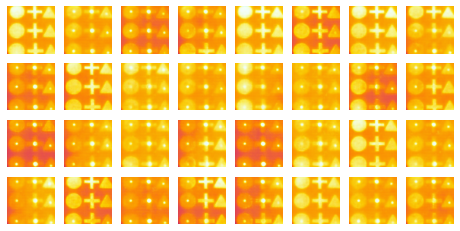

Epoch 282/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5342, mae= 0.3216, acc= 0.7597
GAN: loss= 1.7464, mae= 0.7113, acc= 0.1915
Epoch 283/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5658, mae= 0.3574, acc= 0.7245
GAN: loss= 1.4915, mae= 0.6793, acc= 0.2160
Epoch 284/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5617, mae= 0.3337, acc= 0.7342
GAN: loss= 1.8954, mae= 0.7277, acc= 0.1937
Epoch 285/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5878, mae= 0.3529, acc= 0.7101
GAN: loss= 1.6812, mae= 0.6855, acc= 0.2364
Epoch 286/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5307, mae= 0.3351, acc= 0.7494
GAN: loss= 1.6926, mae= 0.7083, acc= 0.1912
Epoch 287/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.6600, mae= 0.3940, acc= 0.6828
GAN: loss= 1.3359, mae= 0.6279, acc= 0.2770
Epoch 288/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5573, mae= 0.3596, acc= 0.7116
GAN: loss= 1.5042, mae= 0.6774, acc= 0.2266
Epoch 289/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5458, mae= 0.3272, acc= 0.7357
GAN: loss= 2.0805, mae= 0.7429, acc= 0.1726
Epoch 290/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5453, mae= 0.3288, acc= 0.7510
GAN: loss= 1.8982, mae= 0.7248, acc= 0.1794
Epoch 291/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5794, mae= 0.3506, acc= 0.7348
GAN: loss= 1.5872, mae= 0.6885, acc= 0.2013
Epoch 292/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5360, mae= 0.3284, acc= 0.7385
GAN: loss= 1.8555, mae= 0.7191, acc= 0.1911
Epoch 293/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5466, mae= 0.3337, acc= 0.7301
GAN: loss= 1.8685, mae= 0.7211, acc= 0.1978
Epoch 294/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.5540, mae= 0.3130, acc= 0.7575
GAN: loss= 2.1364, mae= 0.7399, acc= 0.1805
Epoch 295/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.5656, mae= 0.3450, acc= 0.7317
GAN: loss= 1.7239, mae= 0.7049, acc= 0.2050
Epoch 296/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5286, mae= 0.3102, acc= 0.7569
GAN: loss= 2.1077, mae= 0.7492, acc= 0.1637
Epoch 297/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5734, mae= 0.3461, acc= 0.7190
GAN: loss= 1.7797, mae= 0.7105, acc= 0.2035
Epoch 298/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5749, mae= 0.3506, acc= 0.7244
GAN: loss= 1.6261, mae= 0.6865, acc= 0.2096
Epoch 299/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5672, mae= 0.3699, acc= 0.7150
GAN: loss= 1.3678, mae= 0.6671, acc= 0.2160
Epoch 300/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5694, mae= 0.3552, acc= 0.7173
GAN: loss= 1.6437, mae= 0.7039, acc= 0.1992
Epoch 301/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5136, mae= 0.3318, acc= 0.7496
GAN: loss= 1.6489, mae= 0.7119, acc= 0.1854


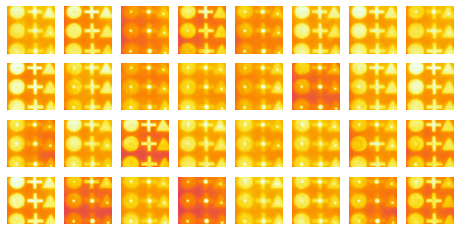

Epoch 302/400


100%|██████████| 228/228 [00:59<00:00,  3.85it/s]


Dis: loss= 0.5498, mae= 0.3404, acc= 0.7272
GAN: loss= 1.8378, mae= 0.7286, acc= 0.1834
Epoch 303/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5894, mae= 0.3451, acc= 0.7421
GAN: loss= 1.6556, mae= 0.6983, acc= 0.1975
Epoch 304/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5818, mae= 0.3310, acc= 0.7360
GAN: loss= 1.9750, mae= 0.7250, acc= 0.1948
Epoch 305/400


100%|██████████| 228/228 [00:58<00:00,  3.92it/s]


Dis: loss= 0.5680, mae= 0.3596, acc= 0.7277
GAN: loss= 1.5033, mae= 0.6839, acc= 0.2116
Epoch 306/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5792, mae= 0.3248, acc= 0.7517
GAN: loss= 1.9318, mae= 0.7185, acc= 0.1998
Epoch 307/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.4697, mae= 0.2934, acc= 0.7959
GAN: loss= 2.1459, mae= 0.7802, acc= 0.1228
Epoch 308/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5219, mae= 0.3148, acc= 0.7467
GAN: loss= 2.0369, mae= 0.7399, acc= 0.1791
Epoch 309/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.4710, mae= 0.2777, acc= 0.7839
GAN: loss= 2.3562, mae= 0.7716, acc= 0.1594
Epoch 310/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5683, mae= 0.3337, acc= 0.7366
GAN: loss= 1.6841, mae= 0.6988, acc= 0.2141
Epoch 311/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.5837, mae= 0.3407, acc= 0.7182
GAN: loss= 2.0109, mae= 0.7278, acc= 0.1986
Epoch 312/400


100%|██████████| 228/228 [00:59<00:00,  3.83it/s]


Dis: loss= 0.5316, mae= 0.3273, acc= 0.7494
GAN: loss= 1.9696, mae= 0.7527, acc= 0.1417
Epoch 313/400


100%|██████████| 228/228 [00:59<00:00,  3.85it/s]


Dis: loss= 0.5377, mae= 0.3107, acc= 0.7603
GAN: loss= 2.0164, mae= 0.7375, acc= 0.1794
Epoch 314/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5107, mae= 0.3055, acc= 0.7584
GAN: loss= 2.2306, mae= 0.7662, acc= 0.1554
Epoch 315/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5794, mae= 0.3418, acc= 0.7359
GAN: loss= 1.7956, mae= 0.7164, acc= 0.1945
Epoch 316/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5608, mae= 0.3517, acc= 0.7186
GAN: loss= 1.6186, mae= 0.6964, acc= 0.2034
Epoch 317/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5657, mae= 0.3349, acc= 0.7237
GAN: loss= 1.9335, mae= 0.7308, acc= 0.1838
Epoch 318/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5119, mae= 0.2919, acc= 0.7743
GAN: loss= 2.4047, mae= 0.7567, acc= 0.1716
Epoch 319/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.4760, mae= 0.2861, acc= 0.7749
GAN: loss= 2.2882, mae= 0.7615, acc= 0.1706
Epoch 320/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5997, mae= 0.3403, acc= 0.7389
GAN: loss= 1.7134, mae= 0.6960, acc= 0.2067
Epoch 321/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5589, mae= 0.3443, acc= 0.7287
GAN: loss= 1.7037, mae= 0.7051, acc= 0.2016


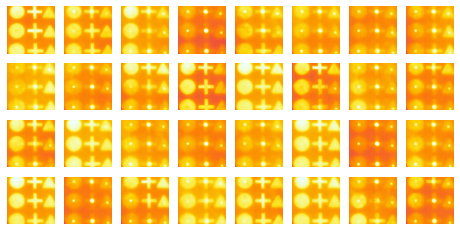

Epoch 322/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5677, mae= 0.3434, acc= 0.7223
GAN: loss= 1.7869, mae= 0.7113, acc= 0.1952
Epoch 323/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5545, mae= 0.3541, acc= 0.7304
GAN: loss= 1.5412, mae= 0.6897, acc= 0.2030
Epoch 324/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.4953, mae= 0.2953, acc= 0.7728
GAN: loss= 2.4576, mae= 0.7761, acc= 0.1498
Epoch 325/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5235, mae= 0.3190, acc= 0.7619
GAN: loss= 2.0146, mae= 0.7375, acc= 0.1657
Epoch 326/400


100%|██████████| 228/228 [00:59<00:00,  3.85it/s]


Dis: loss= 0.5769, mae= 0.3474, acc= 0.7124
GAN: loss= 1.7577, mae= 0.7029, acc= 0.2050
Epoch 327/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5253, mae= 0.3368, acc= 0.7477
GAN: loss= 1.6643, mae= 0.7134, acc= 0.1763
Epoch 328/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5329, mae= 0.3202, acc= 0.7476
GAN: loss= 2.0065, mae= 0.7423, acc= 0.1716
Epoch 329/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5457, mae= 0.3565, acc= 0.7218
GAN: loss= 1.5186, mae= 0.6865, acc= 0.2135
Epoch 330/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5925, mae= 0.3607, acc= 0.6973
GAN: loss= 1.6363, mae= 0.6899, acc= 0.2319
Epoch 331/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5529, mae= 0.3356, acc= 0.7246
GAN: loss= 1.8689, mae= 0.7201, acc= 0.2055
Epoch 332/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5793, mae= 0.3460, acc= 0.7210
GAN: loss= 1.8038, mae= 0.7048, acc= 0.2041
Epoch 333/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5059, mae= 0.3174, acc= 0.7562
GAN: loss= 1.9257, mae= 0.7473, acc= 0.1512
Epoch 334/400


100%|██████████| 228/228 [00:59<00:00,  3.85it/s]


Dis: loss= 0.5621, mae= 0.3273, acc= 0.7245
GAN: loss= 2.1434, mae= 0.7418, acc= 0.1835
Epoch 335/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5140, mae= 0.3198, acc= 0.7532
GAN: loss= 1.9032, mae= 0.7422, acc= 0.1589
Epoch 336/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5720, mae= 0.3198, acc= 0.7356
GAN: loss= 2.3866, mae= 0.7418, acc= 0.1968
Epoch 337/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5279, mae= 0.3392, acc= 0.7407
GAN: loss= 1.6082, mae= 0.6972, acc= 0.2031
Epoch 338/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5702, mae= 0.3504, acc= 0.7226
GAN: loss= 1.6295, mae= 0.6935, acc= 0.2111
Epoch 339/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.5606, mae= 0.3486, acc= 0.7281
GAN: loss= 1.6455, mae= 0.6981, acc= 0.2067
Epoch 340/400


100%|██████████| 228/228 [00:59<00:00,  3.85it/s]


Dis: loss= 0.6072, mae= 0.3556, acc= 0.7024
GAN: loss= 1.7740, mae= 0.7015, acc= 0.2144
Epoch 341/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.5926, mae= 0.3382, acc= 0.7323
GAN: loss= 1.8751, mae= 0.7242, acc= 0.1878


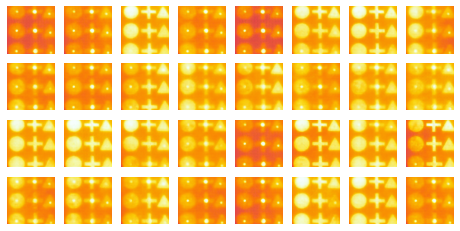

Epoch 342/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5316, mae= 0.3297, acc= 0.7439
GAN: loss= 1.7561, mae= 0.7188, acc= 0.1816
Epoch 343/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5683, mae= 0.3514, acc= 0.7179
GAN: loss= 1.7206, mae= 0.7117, acc= 0.2004
Epoch 344/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5588, mae= 0.3393, acc= 0.7290
GAN: loss= 1.8508, mae= 0.7217, acc= 0.1856
Epoch 345/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5173, mae= 0.2989, acc= 0.7669
GAN: loss= 2.2536, mae= 0.7826, acc= 0.1273
Epoch 346/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.5169, mae= 0.3200, acc= 0.7612
GAN: loss= 1.6878, mae= 0.7043, acc= 0.1972
Epoch 347/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5766, mae= 0.3444, acc= 0.7242
GAN: loss= 1.7812, mae= 0.7142, acc= 0.1997
Epoch 348/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5719, mae= 0.3726, acc= 0.6954
GAN: loss= 1.4456, mae= 0.6701, acc= 0.2241
Epoch 349/400


100%|██████████| 228/228 [00:58<00:00,  3.93it/s]


Dis: loss= 0.5739, mae= 0.3491, acc= 0.7172
GAN: loss= 1.7165, mae= 0.7019, acc= 0.2064
Epoch 350/400


100%|██████████| 228/228 [00:59<00:00,  3.85it/s]


Dis: loss= 0.5111, mae= 0.3047, acc= 0.7679
GAN: loss= 2.1249, mae= 0.7448, acc= 0.1734
Epoch 351/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5330, mae= 0.3431, acc= 0.7373
GAN: loss= 1.6517, mae= 0.7073, acc= 0.1857
Epoch 352/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5482, mae= 0.3237, acc= 0.7394
GAN: loss= 2.0583, mae= 0.7435, acc= 0.1800
Epoch 353/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5044, mae= 0.3175, acc= 0.7575
GAN: loss= 1.8602, mae= 0.7349, acc= 0.1687
Epoch 354/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.4997, mae= 0.3130, acc= 0.7626
GAN: loss= 1.9160, mae= 0.7453, acc= 0.1591
Epoch 355/400


100%|██████████| 228/228 [00:59<00:00,  3.83it/s]


Dis: loss= 0.5344, mae= 0.3077, acc= 0.7601
GAN: loss= 2.1666, mae= 0.7533, acc= 0.1643
Epoch 356/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5928, mae= 0.3398, acc= 0.7390
GAN: loss= 1.7611, mae= 0.7033, acc= 0.1927
Epoch 357/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.5147, mae= 0.3176, acc= 0.7477
GAN: loss= 2.0247, mae= 0.7455, acc= 0.1708
Epoch 358/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5353, mae= 0.2976, acc= 0.7623
GAN: loss= 2.3223, mae= 0.7672, acc= 0.1665
Epoch 359/400


100%|██████████| 228/228 [00:59<00:00,  3.85it/s]


Dis: loss= 0.5054, mae= 0.3066, acc= 0.7647
GAN: loss= 1.9718, mae= 0.7491, acc= 0.1590
Epoch 360/400


100%|██████████| 228/228 [00:59<00:00,  3.83it/s]


Dis: loss= 0.5096, mae= 0.2978, acc= 0.7614
GAN: loss= 2.3402, mae= 0.7821, acc= 0.1414
Epoch 361/400


100%|██████████| 228/228 [00:59<00:00,  3.84it/s]


Dis: loss= 0.5670, mae= 0.3504, acc= 0.7281
GAN: loss= 1.5750, mae= 0.6941, acc= 0.1963


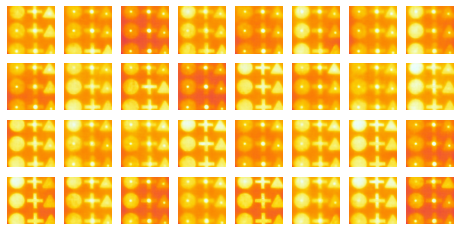

Epoch 362/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.5106, mae= 0.3274, acc= 0.7471
GAN: loss= 1.7943, mae= 0.7291, acc= 0.1694
Epoch 363/400


100%|██████████| 228/228 [00:59<00:00,  3.84it/s]


Dis: loss= 0.5795, mae= 0.3390, acc= 0.7269
GAN: loss= 1.8484, mae= 0.7149, acc= 0.1970
Epoch 364/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.4849, mae= 0.3208, acc= 0.7645
GAN: loss= 1.6298, mae= 0.7094, acc= 0.1834
Epoch 365/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.5692, mae= 0.3259, acc= 0.7242
GAN: loss= 2.0243, mae= 0.7284, acc= 0.2008
Epoch 366/400


100%|██████████| 228/228 [00:59<00:00,  3.83it/s]


Dis: loss= 0.5422, mae= 0.3455, acc= 0.7362
GAN: loss= 1.5595, mae= 0.7007, acc= 0.1927
Epoch 367/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5041, mae= 0.3259, acc= 0.7517
GAN: loss= 1.8264, mae= 0.7334, acc= 0.1642
Epoch 368/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5619, mae= 0.3364, acc= 0.7296
GAN: loss= 1.8776, mae= 0.7254, acc= 0.1830
Epoch 369/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.4880, mae= 0.3053, acc= 0.7656
GAN: loss= 2.0594, mae= 0.7550, acc= 0.1464
Epoch 370/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.5037, mae= 0.2977, acc= 0.7700
GAN: loss= 2.1609, mae= 0.7586, acc= 0.1631
Epoch 371/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5356, mae= 0.3292, acc= 0.7380
GAN: loss= 1.9714, mae= 0.7307, acc= 0.1797
Epoch 372/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.4847, mae= 0.2990, acc= 0.7705
GAN: loss= 2.0774, mae= 0.7585, acc= 0.1601
Epoch 373/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5401, mae= 0.3171, acc= 0.7555
GAN: loss= 1.8230, mae= 0.7138, acc= 0.2060
Epoch 374/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.4302, mae= 0.2748, acc= 0.7998
GAN: loss= 2.2743, mae= 0.7933, acc= 0.1151
Epoch 375/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5462, mae= 0.2756, acc= 0.7842
GAN: loss= 2.6804, mae= 0.7799, acc= 0.1531
Epoch 376/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.4972, mae= 0.3005, acc= 0.7631
GAN: loss= 2.0632, mae= 0.7433, acc= 0.1772
Epoch 377/400


100%|██████████| 228/228 [00:59<00:00,  3.86it/s]


Dis: loss= 0.4931, mae= 0.3122, acc= 0.7616
GAN: loss= 1.8519, mae= 0.7352, acc= 0.1713
Epoch 378/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.4259, mae= 0.2592, acc= 0.8037
GAN: loss= 2.9421, mae= 0.8354, acc= 0.0933
Epoch 379/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5204, mae= 0.2782, acc= 0.7721
GAN: loss= 2.5010, mae= 0.7603, acc= 0.1842
Epoch 380/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.4887, mae= 0.2992, acc= 0.7769
GAN: loss= 1.9066, mae= 0.7450, acc= 0.1630
Epoch 381/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5163, mae= 0.3101, acc= 0.7529
GAN: loss= 2.1042, mae= 0.7564, acc= 0.1619


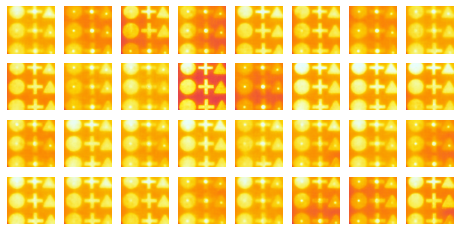

Epoch 382/400


100%|██████████| 228/228 [00:59<00:00,  3.85it/s]


Dis: loss= 0.6249, mae= 0.3625, acc= 0.7018
GAN: loss= 1.5948, mae= 0.6826, acc= 0.2268
Epoch 383/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.4880, mae= 0.3198, acc= 0.7741
GAN: loss= 1.8175, mae= 0.7419, acc= 0.1327
Epoch 384/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5102, mae= 0.2914, acc= 0.7684
GAN: loss= 2.4872, mae= 0.7748, acc= 0.1554
Epoch 385/400


100%|██████████| 228/228 [00:59<00:00,  3.84it/s]


Dis: loss= 0.5453, mae= 0.3168, acc= 0.7450
GAN: loss= 2.2244, mae= 0.7434, acc= 0.1791
Epoch 386/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5159, mae= 0.3190, acc= 0.7507
GAN: loss= 2.0124, mae= 0.7446, acc= 0.1654
Epoch 387/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.6059, mae= 0.3404, acc= 0.7220
GAN: loss= 1.7934, mae= 0.6838, acc= 0.2227
Epoch 388/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5266, mae= 0.3399, acc= 0.7356
GAN: loss= 1.6213, mae= 0.7122, acc= 0.1743
Epoch 389/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5269, mae= 0.3329, acc= 0.7384
GAN: loss= 1.7113, mae= 0.7214, acc= 0.1735
Epoch 390/400


100%|██████████| 228/228 [00:58<00:00,  3.87it/s]


Dis: loss= 0.5374, mae= 0.3161, acc= 0.7546
GAN: loss= 2.0632, mae= 0.7486, acc= 0.1690
Epoch 391/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5852, mae= 0.3172, acc= 0.7377
GAN: loss= 2.2641, mae= 0.7469, acc= 0.1764
Epoch 392/400


100%|██████████| 228/228 [00:58<00:00,  3.86it/s]


Dis: loss= 0.5296, mae= 0.3090, acc= 0.7546
GAN: loss= 2.1172, mae= 0.7515, acc= 0.1706
Epoch 393/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]


Dis: loss= 0.5232, mae= 0.3318, acc= 0.7413
GAN: loss= 1.6878, mae= 0.7087, acc= 0.1961
Epoch 394/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5292, mae= 0.3286, acc= 0.7438
GAN: loss= 1.8615, mae= 0.7241, acc= 0.1835
Epoch 395/400


100%|██████████| 228/228 [00:58<00:00,  3.88it/s]


Dis: loss= 0.5530, mae= 0.3498, acc= 0.7194
GAN: loss= 1.6013, mae= 0.7015, acc= 0.1845
Epoch 396/400


100%|██████████| 228/228 [00:58<00:00,  3.89it/s]


Dis: loss= 0.5925, mae= 0.3313, acc= 0.7234
GAN: loss= 2.1009, mae= 0.7382, acc= 0.1876
Epoch 397/400


100%|██████████| 228/228 [00:59<00:00,  3.85it/s]


Dis: loss= 0.5038, mae= 0.3217, acc= 0.7545
GAN: loss= 1.7242, mae= 0.7147, acc= 0.1875
Epoch 398/400


100%|██████████| 228/228 [00:57<00:00,  3.94it/s]


Dis: loss= 0.5871, mae= 0.3483, acc= 0.7317
GAN: loss= 1.6135, mae= 0.6962, acc= 0.1928
Epoch 399/400


100%|██████████| 228/228 [00:58<00:00,  3.91it/s]


Dis: loss= 0.5472, mae= 0.3468, acc= 0.7246
GAN: loss= 1.6020, mae= 0.7000, acc= 0.1998
Epoch 400/400


100%|██████████| 228/228 [00:58<00:00,  3.90it/s]

Dis: loss= 0.5595, mae= 0.3309, acc= 0.7351
GAN: loss= 1.8247, mae= 0.7165, acc= 0.2016


In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs= 400)

In [4]:
gan = keras.models.load_model("drive/MyDrive/models/GAN/5_1_gan_300.hdf5")

In [7]:
discriminator = gan.layers[1]

In [28]:
path = glob.glob("./clean-normal/*.jpg")
images = []
for file in tqdm(path):
  img = plt.imread(file)
  img = img[30:-50]
  img = cv2.resize(img, (256,256))
  img = img  / 255. * 2. - 1.
  images.append(img)
  
images = np.asarray(images)
y = discriminator.predict(images)

100%|██████████| 7302/7302 [00:16<00:00, 435.06it/s]


In [41]:
print(len(y [y > 0.3]))  ## Propapility the instance belongs to class 1.

7296
0


In [31]:
path = glob.glob("./fail/*.jpg")
images = []
for file in tqdm(path):
  img = plt.imread(file)
  img = img[30:-50]
  img = cv2.resize(img, (256,256))
  img = img  / 255. 
  images.append(img)
  
images = np.asarray(images)
z = discriminator.predict(images)

100%|██████████| 2476/2476 [00:05<00:00, 459.81it/s]


In [42]:
print(len(z [z < 0.1]))  ## Propapility the instance belongs to class 1.

2476
0


In [27]:
y

array([[1.16496005e-04],
       [9.59783210e-05],
       [7.53045533e-05],
       ...,
       [8.97208229e-05],
       [1.29062610e-04],
       [1.04346778e-04]], dtype=float32)

In [22]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)      